# Homework 2 Problem 3 Sentiment Analysis with word-embeddings

In this assignment we use a neural network for classifying movie reviews.  The neural network includes a word embedding layer.  

For pre-processing the data we'll use the torchtext package of PyTorch.  All the torchtext code is already provided.  [Documentation](https://pytorch.org/text/) for torchtext is relatively sparse, but [Ben Trevett](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/1%20-%20Simple%20Sentiment%20Analysis.ipynb) has a useful tutorial.

You have to add missing code indicated by ##YOUR CODE HERE##.

You can optionally run the notebook on [Google Colab](https://colab.research.google.com). To upload a notebook, choose the "Files" dropdown menu and then "Upload."
To use a GPU, choose Runtime > Change runtime type and select GPU.

We use torchtext to create vocabulary, and load datasets into batches.

In [1]:
import random
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchtext import data
SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# We are using 'spacy' tokenizer. You can also write your own tokenizer. You can 
# download spacy from https://spacy.io/usage
TEXT = data.Field(tokenize = 'spacy')
LABEL = data.LabelField(dtype = torch.float)

Fortunately, torchtext has a convenient method to load the movie review dataset. Loading may take 10 to 15 minutes.

In [2]:
from torchtext import datasets

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)
train_data, valid_data = train_data.split(random_state = random.seed(SEED))

In [3]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')
print(f'Number of validation examples:{len(test_data)}')

Number of training examples: 17500
Number of testing examples: 25000
Number of validation examples:25000


Now we build our vocabulary/dictionary. We are only keeping 25,000 most common words.

In [4]:
MAX_VOCAB_SIZE = 25000

TEXT.build_vocab(train_data, max_size = MAX_VOCAB_SIZE)

# If you want to use pretrained GloVe (https://nlp.stanford.edu/projects/glove/)
# replace above code with the one below.
# TEXT.build_vocab(train_data, 
#                 max_size = MAX_VOCAB_SIZE, 
#                 vectors = "glove.6B.100d", 
#                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

Functions `itos` (int to string) and `stoi` map indices to words in the vocabulary.

In [5]:
print(TEXT.vocab.itos[:10])

['<unk>', '<pad>', 'the', ',', '.', 'a', 'and', 'of', 'to', 'is']


Iterators construct batches of data for every iteration of mini-batch gradient descent. They also pad sentences to make sure all sentences in a batch have equal length, so that they can be processed in parallel.

In [6]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device)

In [8]:
def binary_accuracy(preds, y):
    """
    Return accuracy per batch
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc



The `class WordEmbAvg` defines our model:

1. The input is a batch of sentences, padded if necessary to have equal lengths.  Each word in a sentence is simply its index corresponding to a one-hot encoding.

2. The input first passes through an embedding layer which converts each word into a dense word vector.  A sentence is now represented by the mean of all its word vectors.  You may optionally want to read Robert Guthrie's [tutorial on embeddings](https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html).

4. The input then passes through one or more neural network layers, which include a non-linearity such as ReLU.

4. Since the output is binary, we use the binary cross entropy loss.


### Note: I've made some modifications to the general class code in order to facilitate my open-ended improvements later.

In [12]:


class WordEmbAvg(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, pad_idx, two_layers=True, dropout_p=0.0):
        
        super().__init__()
        
        # Define an embedding layer, a couple of linear layers, and 
        # the ReLU non-linearity.

        ##YOUR CODE HERE##
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        if two_layers == True:
            self.linear1 = nn.Linear(embedding_dim, hidden_dim)
            self.linear2 = nn.Linear(hidden_dim, output_dim) 
        else:
            self.linear1 = nn.Linear(embedding_dim, output_dim)
            self.linear2 = None
        self.relu = nn.ReLU()
        self.drop_layer = nn.Dropout(p=dropout_p)

        
        
    def forward(self, text):

        ##YOUR CODE HERE##
        embedded = self.embedding(text)
        embedded = embedded.mean(0)
        if not self.linear2:
            linear1_output = self.linear1(embedded)
            output = self.relu(linear1_output)
            output = self.drop_layer(output)
            return output
        else:
            linear1_output = self.linear1(embedded)
            linear2_input = self.relu(linear1_output)
            output = self.linear2(linear2_input)
            output = self.drop_layer(output)
            return output
    
    


In [13]:
class Training_module( ):

    def __init__(self, model):
        self.model = model
        self.loss_fn = nn.BCEWithLogitsLoss()
        ##YOUR CODE HERE##
        # Choose an optimizer. optim.Adam is a popular choice
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-3)
    
    def train_epoch(self, iterator):
        '''
        Train the model for one epoch. For this repeat the following, 
        going through all training examples.
        1. Get the next batch of inputs from the iterator.
        2. Determine the predictions using a forward pass.
        3. Compute the loss.
        4. Compute gradients using a backward pass.
        5. Execute one step of the optimizer to update the model paramters.
        '''
        epoch_loss = 0
        epoch_acc = 0
    
        for batch in iterator:
          # batch.text has the texts and batch.label has the labels.
        
            self.optimizer.zero_grad()
                
            ##YOUR CODE HERE##
            
            predictions = self.model(batch.text).squeeze(1)
            loss = self.loss_fn(predictions, batch.label)
            accuracy = binary_accuracy(predictions, batch.label)
        
            loss.backward()
            self.optimizer.step()
            epoch_loss += loss.item()
            epoch_acc += accuracy.item()
        
        return epoch_loss / len(iterator), epoch_acc / len(iterator)
    
    def train_model(self, train_iterator, dev_iterator, num_epochs=5):
        """
        Train the model for multiple epochs, and after each evaluate on the
        development set.  Return the best performing model.
        """  
        dev_accs = [0.]
        for epoch in range(num_epochs):
            self.train_epoch(train_iterator)
            dev_acc = self.evaluate(dev_iterator)
            print(f"Epoch {epoch}: Dev Accuracy: {dev_acc[1]} Dev Loss:{dev_acc[0]}")
            if dev_acc[1] > max(dev_accs):
                best_model = copy.deepcopy(self)
            dev_accs.append(dev_acc[1])
        return best_model.model
                
    def evaluate(self, iterator):
        '''
        Evaluate the performance of the model on the given examples.
        '''
        epoch_loss = 0
        epoch_acc = 0
    
        with torch.no_grad():
    
            for batch in iterator:
                
                predictions = self.model(batch.text).squeeze(1)
            
                loss = self.loss_fn(predictions, batch.label)
            
                acc = binary_accuracy(predictions, batch.label)
        
                epoch_loss += loss.item()
                epoch_acc += acc.item()
        
        return epoch_loss / len(iterator), epoch_acc / len(iterator)
    
    
        

In [14]:
INPUT_DIM = len(TEXT.vocab)
#You can try many different embedding dimensions. Common values are 20, 32, 64, 100, 128, 512
EMBEDDING_DIM = 100
HIDDEN_DIM = 50
OUTPUT_DIM = 1
#Get the index of the pad token using the stoi function
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]


model = WordEmbAvg(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, PAD_IDX)

# If you want to use pre-trained embeddings uncomment following
# pretrained_embeddings = TEXT.vocab.vectors
# model.embedding.weight.data.copy_(pretrained_embeddings)
# UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
# model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
# model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [15]:
model = model.to(device)
tm = Training_module(model)

#Training the model
best_model = tm.train_model(train_iterator, valid_iterator)

Epoch 0: Dev Accuracy: 0.7074505651401262 Dev Loss:0.6477360260688653
Epoch 1: Dev Accuracy: 0.771583686440678 Dev Loss:0.49885147456395423
Epoch 2: Dev Accuracy: 0.8253001414113126 Dev Loss:0.45554294525566746
Epoch 3: Dev Accuracy: 0.854740466101695 Dev Loss:0.4318647619526265
Epoch 4: Dev Accuracy: 0.8686882060463146 Dev Loss:0.4392612533549131


In [16]:
# Determine accuracy of best model. You should obtain a test accuracy 
# well above 80%.
tm.model = best_model
test_loss, test_acc = tm.evaluate(test_iterator)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.476 | Test Acc: 85.83%


During training the embeddings are also trained.  Compute the norms of the final word vectors and list the 10 words with highest norm values and 10 with the lowest. Analyze your results.

In [17]:
##YOUR CODE HERE###

norms = torch.norm(best_model.embedding.weight, p=2, dim=1, keepdim=True).data.squeeze()
norms

tensor([10.1980,  9.8359, 10.7522,  ..., 11.0455, 10.2977, 10.3934])

In [18]:
highest_10 = norms.argsort()[-10:]

In [21]:
for i in highest_10:
    print(TEXT.vocab.itos[i])

great
excellent
horrible
lame
terrible
waste
awful
boring
worst
bad


The 10 words with highest norm values all convey strong connotations of quality (e.g. "excellent", "horrible") or emotional reaction (e.g. "boring", "lame"). It thus makes sense that these words have substantial weight in determining the sentiment of a review.

In [22]:
lowest_10 = norms.argsort()[:10]

In [25]:
for i in lowest_10:
    print(TEXT.vocab.itos[i])

Benedict
EUROPA
musician
superstar
misrepresentation
Eaters
Stephens
specialized
Hilary
Blooded


The 10 words with lowest norm values all seem essentially random (e.g. "Benedict", "EUROPA"), are mostly nouns, and do not convey much information about the reviewer's emotional reaction to the movie or their assessment of the movie's quality. It thus makes sense that these words have little weight in determining the sentiment of a review.

## Open ended improvements

Experiment with some improvements such as---
- increasing number of training epochs
- using pre-trained embeddings
- using different optimizers
- increasing number of layers
- using different non-linearities
- adding drop outs
- changing number of embedding/hidden dimensions

Describe what you did, what results you obtained, and what you have learned from it.




### Varying training epochs

I varied the number of training epochs, and found that test accuracy increases with the number of training epochs. I thus learned that having a higher number of training epochs is better if possible.

In [23]:
for epoch_num in [2, 7, 10]:
    print(f'Number of epochs: {epoch_num}')
    model = WordEmbAvg(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, PAD_IDX)
    model = model.to(device)
    tm = Training_module(model)
    epoch_model = tm.train_model(train_iterator, valid_iterator, epoch_num)
    tm.model = epoch_model
    test_loss, test_acc = tm.evaluate(test_iterator)
    print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Number of epochs: 2
Epoch 0: Dev Accuracy: 0.6847634184158454 Dev Loss:0.6546682629544857
Epoch 1: Dev Accuracy: 0.7474841101694916 Dev Loss:0.5319508692975772
Test Loss: 0.539 | Test Acc: 74.10%
Number of epochs: 7
Epoch 0: Dev Accuracy: 0.627780720338983 Dev Loss:0.6688318939532264
Epoch 1: Dev Accuracy: 0.7421433617502956 Dev Loss:0.5229855851601746
Epoch 2: Dev Accuracy: 0.8114406779661016 Dev Loss:0.4500384816931466
Epoch 3: Dev Accuracy: 0.8498411016949152 Dev Loss:0.4272268547723859
Epoch 4: Dev Accuracy: 0.8659957627118644 Dev Loss:0.43339237280316273
Epoch 5: Dev Accuracy: 0.8757944915254238 Dev Loss:0.4555735600701833
Epoch 6: Dev Accuracy: 0.8807379946870318 Dev Loss:0.46121951186303367
Test Loss: 0.499 | Test Acc: 86.84%
Number of epochs: 10
Epoch 0: Dev Accuracy: 0.5963983050847458 Dev Loss:0.6632749519105685
Epoch 1: Dev Accuracy: 0.7505737997717776 Dev Loss:0.5064906733015836
Epoch 2: Dev Accuracy: 0.8072916668350414 Dev Loss:0.46505146069546877
Epoch 3: Dev Accuracy: 0.

### Pre-trained embeddings

I used pre-trained GloVe embeddings, and while test accuracy was still high, the 10 words with highest norm turned out to be much less meaningful than the embeddings which were trained with the model. While some of the words were still meaningful (e.g. "worst", "awful", "waste"), many others were not helpful for discerning review sentiment (e.g. "Pikachu" and "BLUE"). This suggests that using pre-trained embeddings is not always ideal, because they are less sensitive to the specific context of the data.

In [24]:
TEXT.build_vocab(train_data, 
                max_size = MAX_VOCAB_SIZE, 
                vectors = "glove.6B.100d", 
                unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [06:28, 2.22MB/s]                           
100%|█████████▉| 399918/400000 [00:18<00:00, 26674.92it/s]

In [0]:
model = WordEmbAvg(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, PAD_IDX)

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [0]:
model = model.to(device)
tm = Training_module(model)

In [0]:
embed_model = tm.train_model(train_iterator, valid_iterator)

Epoch 0: Dev Accuracy: 0.7459392658734726 Dev Loss:0.5555016847990327
Epoch 1: Dev Accuracy: 0.8579184322033898 Dev Loss:0.4907523751637693
Epoch 2: Dev Accuracy: 0.8799435031616082 Dev Loss:0.5484272344827147
Epoch 3: Dev Accuracy: 0.8906691387548284 Dev Loss:0.5707008521056781
Epoch 4: Dev Accuracy: 0.8910663845175404 Dev Loss:0.6512995676721557


In [0]:
tm.model = embed_model
test_loss, test_acc = tm.evaluate(test_iterator)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.715 | Test Acc: 87.81%


In [0]:
norms = torch.norm(embed_model.embedding.weight, p=2, dim=1, keepdim=True).data.squeeze()

In [0]:
highest_10 = norms.argsort()[-10:]
for i in highest_10:
    print(TEXT.vocab.itos[i])

BLUE
Bugs
Dangerfield
/>1
Boo
awful
Jud
Pikachu
waste
worst


In [0]:
lowest_10 = norms.argsort()[:10]
for i in lowest_10:
    print(TEXT.vocab.itos[i])

<pad>
<unk>
lastly
i.e
incidentally
cuties
scariness
hehe
coincidentally
interestingly


### Optimizers

I varied the optimizers used for training; I tried out SGD and Adagrad. Both of them yielded substantially lower test accuracy than the suggested Adam optimizer. However, given the variety of optimizers available, it is not likely that Adam is the best optimizer in every case; this seems like an indication that I should test out various optimizers and that no single optimizer is automatically the best for every case.

In [0]:
model = WordEmbAvg(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, PAD_IDX)
model = model.to(device)
tm = Training_module(model)
tm.optimizer = optim.SGD(tm.model.parameters(), lr=1e-3)
optim_model = tm.train_model(train_iterator, valid_iterator)
tm.model = optim_model
test_loss, test_acc = tm.evaluate(test_iterator)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Epoch 0: Dev Accuracy: 0.554996469263303 Dev Loss:0.6917192198462405
Epoch 1: Dev Accuracy: 0.548110876042964 Dev Loss:0.6916645174309358
Epoch 2: Dev Accuracy: 0.5427259888689396 Dev Loss:0.6916403305732598
Epoch 3: Dev Accuracy: 0.541843220338983 Dev Loss:0.6916252682774754
Epoch 4: Dev Accuracy: 0.5398569915254238 Dev Loss:0.6916107707104441
Test Loss: 0.692 | Test Acc: 54.89%


In [0]:
model = WordEmbAvg(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, PAD_IDX)
model = model.to(device)
tm = Training_module(model)
tm.optimizer = optim.Adagrad(tm.model.parameters(), lr=1e-3)
optim_model = tm.train_model(train_iterator, valid_iterator)
tm.model = optim_model
test_loss, test_acc = tm.evaluate(test_iterator)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Epoch 0: Dev Accuracy: 0.4920550847457627 Dev Loss:0.693897148815252
Epoch 1: Dev Accuracy: 0.4921875 Dev Loss:0.6930469436160589
Epoch 2: Dev Accuracy: 0.4927171610169492 Dev Loss:0.6923265138925132
Epoch 3: Dev Accuracy: 0.4949682203389831 Dev Loss:0.6916322248466944
Epoch 4: Dev Accuracy: 0.5033103813559322 Dev Loss:0.6909905909481695
Test Loss: 0.690 | Test Acc: 51.35%


### Non-linearities

I tried out different non-linearities for the model, specifically tanh and sigmoid functions. These led to variations in test accuracy, but it remained high (above 80%). Again, this indicates that it may be worth testing out various non-linearities, and no single one is automatically the best in every case.

In [0]:
model = WordEmbAvg(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, PAD_IDX)
model.relu = nn.Tanh()
model = model.to(device)
tm = Training_module(model)
nonlinear_model = tm.train_model(train_iterator, valid_iterator)
tm.model = nonlinear_model
test_loss, test_acc = tm.evaluate(test_iterator)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Epoch 0: Dev Accuracy: 0.597545904123177 Dev Loss:0.6596137563050803
Epoch 1: Dev Accuracy: 0.7564883474576272 Dev Loss:0.5833031421495696
Epoch 2: Dev Accuracy: 0.8306408898305084 Dev Loss:0.6003537809444686
Epoch 3: Dev Accuracy: 0.8599046610169492 Dev Loss:0.5965881591378632
Epoch 4: Dev Accuracy: 0.8735875709582184 Dev Loss:0.6144532627599725
Test Loss: 0.667 | Test Acc: 86.05%


In [0]:
model = WordEmbAvg(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, PAD_IDX)
model.relu = nn.Sigmoid()
model = model.to(device)
tm = Training_module(model)
nonlinear_model = tm.train_model(train_iterator, valid_iterator)
tm.model = nonlinear_model
test_loss, test_acc = tm.evaluate(test_iterator)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Epoch 0: Dev Accuracy: 0.5451536016949152 Dev Loss:0.6812719041008061
Epoch 1: Dev Accuracy: 0.6897510593220338 Dev Loss:0.6177405432119207
Epoch 2: Dev Accuracy: 0.7408192092079228 Dev Loss:0.5235073142132517
Epoch 3: Dev Accuracy: 0.7943149719197872 Dev Loss:0.5128692675192478
Epoch 4: Dev Accuracy: 0.832229872881356 Dev Loss:0.49679571983672804
Test Loss: 0.521 | Test Acc: 82.48%


### Number of layers

I tried out having one neural network layer instead of two. This lowered the test accuracy below 80%, suggesting that it is preferable to have more layers, or at least more than a single layer.

In [0]:
model = WordEmbAvg(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, PAD_IDX, two_layers=False)
model = model.to(device)
tm = Training_module(model)
onelayer_model = tm.train_model(train_iterator, valid_iterator)
tm.model = onelayer_model
test_loss, test_acc = tm.evaluate(test_iterator)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Epoch 0: Dev Accuracy: 0.5144332627118644 Dev Loss:0.6853451602539774
Epoch 1: Dev Accuracy: 0.6655190677966102 Dev Loss:0.6520211984545498
Epoch 2: Dev Accuracy: 0.7319473871740244 Dev Loss:0.6150273604918335
Epoch 3: Dev Accuracy: 0.7580331922587702 Dev Loss:0.5814293021872893
Epoch 4: Dev Accuracy: 0.7898569915254238 Dev Loss:0.555798538660599
Test Loss: 0.563 | Test Acc: 78.51%


### Drop-outs

Drop-out is a form of regularization, i.e. avoiding neural network overfitting by randomly dropping out nodes. I varied the probability of drop-out, at various intervals from 0 to 0.75. I found that increasing the drop-out probability caused the test accuracy to decrease, presumably since information was being discarded; however, this does not mean that including drop-out has no value. It may be more beneficial in larger networks that are more prone to overfitting, e.g. networks with more layers.

In [0]:
for dropout_rate in [0, 0.1, 0.25, 0.5, 0.75]:
    print(f'Dropout rate: {dropout_rate}')
    model = WordEmbAvg(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, PAD_IDX, dropout_p=dropout_rate)
    model = model.to(device)
    tm = Training_module(model)
    dropout_model = tm.train_model(train_iterator, valid_iterator)
    tm.model = dropout_model
    test_loss, test_acc = tm.evaluate(test_iterator)
    print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Dropout rate: 0
Epoch 0: Dev Accuracy: 0.5157132770045328 Dev Loss:0.6776465182587251
Epoch 1: Dev Accuracy: 0.7529572743480488 Dev Loss:0.5108700614359419
Epoch 2: Dev Accuracy: 0.8094985879073708 Dev Loss:0.43932692352998054
Epoch 3: Dev Accuracy: 0.8567266949152542 Dev Loss:0.420237921683465
Epoch 4: Dev Accuracy: 0.874073093220339 Dev Loss:0.4217579244493933
Test Loss: 0.457 | Test Acc: 85.86%
Dropout rate: 0.1
Epoch 0: Dev Accuracy: 0.5324417372881356 Dev Loss:0.678965626631753
Epoch 1: Dev Accuracy: 0.6975635593220338 Dev Loss:0.5910971189959574
Epoch 2: Dev Accuracy: 0.740642655703981 Dev Loss:0.5083951793484769
Epoch 3: Dev Accuracy: 0.7972722457627118 Dev Loss:0.47068602490728184
Epoch 4: Dev Accuracy: 0.8152365820892786 Dev Loss:0.46278424384230277
Test Loss: 0.478 | Test Acc: 81.51%
Dropout rate: 0.25
Epoch 0: Dev Accuracy: 0.5274540963819472 Dev Loss:0.6766419233912129
Epoch 1: Dev Accuracy: 0.67845162446216 Dev Loss:0.579347625374794
Epoch 2: Dev Accuracy: 0.72020656779661

### Number of embeddings/hidden dimensions

I varied the numbers of embedding dimensions and hidden dimensions, and found that increasing the number of embedding dimensions led to an increase in test accuracy, although this effect plateaued eventually. (See graphs below.)

Increasing the number of hidden dimensions generally led to an increase in test accuracy, but this effect was more complex; when the number of embedding dimensions was relatively small, an increase in the number of hidden dimensions actually led to a decrease in test accuracy beyond a certain point. (See graphs below.)

This suggests that trial and error is required to determine the optimal numbers of embedding dimensions and hidden dimensions for a given situation.

In [0]:
import pandas as pd

In [0]:
df = pd.DataFrame(columns=['embedding', 'hidden', 'accuracy'])
for embed_dimension in [20, 32, 64, 100]:
    for hidden_dimension in [10, 25, 40, 50]:
        print(f'Embedding dimensions: {embed_dimension}, Hidden dimensions: {hidden_dimension}')
        model = WordEmbAvg(INPUT_DIM, embed_dimension, hidden_dimension, OUTPUT_DIM, PAD_IDX)
        model = model.to(device)
        tm = Training_module(model)
        dim_model = tm.train_model(train_iterator, valid_iterator)
        tm.model = dim_model
        test_loss, test_acc = tm.evaluate(test_iterator)
        print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')
        row = [embed_dimension, hidden_dimension, test_acc*100]
        df.loc[len(df)] = row

Embedding dimensions: 20, Hidden dimensions: 10
Epoch 0: Dev Accuracy: 0.4973516949152542 Dev Loss:0.687568541805623
Epoch 1: Dev Accuracy: 0.7016242939536854 Dev Loss:0.6520565187526961
Epoch 2: Dev Accuracy: 0.7283721753096176 Dev Loss:0.5631650054858903
Epoch 3: Dev Accuracy: 0.7577683617502956 Dev Loss:0.4957691658351381
Epoch 4: Dev Accuracy: 0.7963012007333464 Dev Loss:0.4666768650887376
Test Loss: 0.479 | Test Acc: 79.00%
Embedding dimensions: 20, Hidden dimensions: 25
Epoch 0: Dev Accuracy: 0.5140360169491526 Dev Loss:0.6869941848819539
Epoch 1: Dev Accuracy: 0.6948711159875838 Dev Loss:0.6369277233794585
Epoch 2: Dev Accuracy: 0.736846751580804 Dev Loss:0.5257563431889324
Epoch 3: Dev Accuracy: 0.7798817092079228 Dev Loss:0.509728267788887
Epoch 4: Dev Accuracy: 0.8238877118644068 Dev Loss:0.48167250318042304
Test Loss: 0.502 | Test Acc: 81.42%
Embedding dimensions: 20, Hidden dimensions: 40
Epoch 0: Dev Accuracy: 0.6334745762711864 Dev Loss:0.6846895258305437
Epoch 1: Dev Acc

In [0]:
df

,embedding,hidden,accuracy
0,20.0,10.0,79.002558
1,20.0,25.0,81.416240
2,20.0,40.0,82.721387
3,20.0,50.0,79.346228
4,32.0,10.0,79.680307
5,32.0,25.0,82.920396
6,32.0,40.0,82.463235
7,32.0,50.0,82.419278
8,64.0,10.0,83.046675
9,64.0,25.0,83.919437


In [0]:
df.groupby('embedding')['accuracy'].mean()

embedding
20.0     80.621603
32.0     81.870804
64.0     84.022938
100.0    84.540841
Name: accuracy, dtype: float64

In [0]:
df.groupby('hidden')['accuracy'].mean()

hidden
10.0    81.289762
25.0    83.238691
40.0    83.575767
50.0    82.951966
Name: accuracy, dtype: float64

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


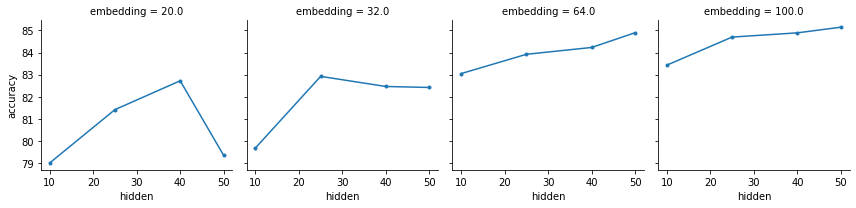

In [0]:
g = sns.FacetGrid(df, col="embedding")
g = g.map(plt.plot, "hidden", "accuracy", marker=".")

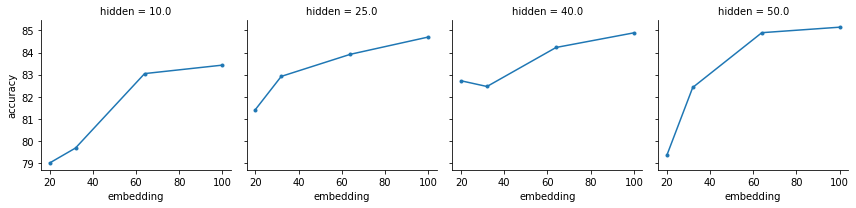

In [0]:
g = sns.FacetGrid(df, col="hidden")
g = g.map(plt.plot, "embedding", "accuracy", marker=".")

In [0]:
# If you would like to save or load models after you have trained them, 
# use the following code.

# To save a model. You can ignore any warnings
torch.save(best_model.state_dict,'best_model')

## To load a model
best_model.load_state_dict('best_model')